In [111]:
import gym
import numpy as np

# Creating the Cart-Pole game environment
env = gym.make('CartPole-v1')

# environment details
print('Number of possible actions:', env.action_space.n)
print('States:', env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)

Number of possible actions: 2
States: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

In [112]:
from time import sleep

actions = []  # actions that the agent selects
rewards = []  # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    result = env.step(action)
    state, reward, done, _ = result[:4]  # Use only the first four values
    env.render()
    sleep(0.15)
    rewards.append(reward)
    actions.append(action)
    if done:
        env.close()
        break

print('Actions:', actions)
print('Rewards:', rewards)


Actions: [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [118]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

def fully_connected(name, input_tensor, num_units, activation=tf.nn.relu):
    """Returns a fully connected layer"""
    with tf.compat.v1.variable_scope(name, reuse=tf.compat.v1.AUTO_REUSE):
        # initialize weights
        w = tf.compat.v1.get_variable(f"W_{name}", shape=[input_tensor.get_shape()[1], num_units],
                                      initializer=tf.compat.v1.initializers.he_uniform(),
                                      dtype=tf.float32, trainable=True)
        # initialize bias
        b = tf.compat.v1.get_variable(f"B_{name}", shape=[num_units], 
                                      initializer=tf.constant_initializer(0.0), 
                                      dtype=tf.float32,
                                      trainable=True)
        # output
        out = tf.matmul(input_tensor, w) + b
        # add activation
        if activation:
            out = activation(out, name=f"activation_{name}")
        # change name
        out = tf.compat.v1.identity(out, name=name)

    return out

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        with tf.compat.v1.variable_scope(name):
            # state inputs to the Q-network
            self.inputs_ = tf.compat.v1.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.compat.v1.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.compat.v1.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = fully_connected("h1", self.inputs_, hidden_size)
            self.fc2 = fully_connected("h2", self.fc1, hidden_size)
            self.fc3 = fully_connected("h3", self.fc2, hidden_size)

            # Linear output layer
            self.output = fully_connected("output", self.fc3, action_size, activation=None)
            
            ### Train using mean squared error and Adam gradient descent.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.loss)


## Experience replay

In [119]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

In [120]:
train_episodes = 700          # max number of episodes to learn from
max_steps = 500               # max steps in an episode
gamma = 1.0                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0002            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 32                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [121]:
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

In [122]:
# Initialize the environment
env.reset()

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    result = env.step(action)
    
    # Check if the result is a tuple and has at least four elements
    if isinstance(result, tuple) and len(result) >= 4:
        state, reward, done, info = result[:4]
        
        # reduce the reward if the cart is not centered
        reward = max(0, reward * (1 - abs(state[0]/2.4)))

        if done:
            # The simulation fails, so no next state
            next_state = np.zeros(state.shape)
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            
            # Start a new episode
            env.reset()
        else:
            # Add experience to memory
            memory.add((state, action, reward, state))  # Assuming state is the next_state
    else:
        raise ValueError("Unexpected result from env.step(): {}".format(result))


## Training

In [123]:
import tensorflow as tf
import numpy as np
from time import sleep
from collections import deque

# Define your QNetwork and Memory classes here if not defined already

class QNetwork(tf.keras.Model):
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
        super(QNetwork, self).__init__(name=name)
        # ... (your QNetwork class definition)
# Create a QNetwork instance
        mainQN = QNetwork()

# Create a Checkpoint object
        checkpoint = tf.train.Checkpoint(model=mainQN)

# Initialize the environment
env.reset()

# ... (your other configurations)

rewards_list = []

# Define a saver object
saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session() as sess:
    # Initialize variables
    sess.run(tf.compat.v1.global_variables_initializer())

    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            env.render()
            sleep(0.0005)

            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * step)
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)

            result = env.step(action)
            next_state, reward, done, _ = result[0], result[1], result[2], result[3]

            reward = max(0, reward * (1 - abs(next_state[0] / 2.4)))
            total_reward += reward

            if done:
                next_state = np.zeros(state.shape)
                t = max_steps

                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))

                memory.add((state, action, reward, next_state))

                env.reset()
                result = env.step(env.action_space.sample())
                state, reward, done, _ = result[0], result[1], result[2], result[3]

            else:
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1

            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])

            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                               feed_dict={mainQN.inputs_: states,
                                          mainQN.targetQs_: targets,
                                          mainQN.actions_: actions})
        
        if len(rewards_list) > 10:
            stop_training = False
            for reward in rewards_list[-10:]:
                if reward[1] < 470:
                    break
            else:
                stop_training = True
            if stop_training:
                break
        
            # Save the model at each episode
            saver.save(sess, "C:/Users/Shubham/Downloads/.ipynb_checkpoints/CartPole.ckpt")


Episode: 1 Total reward: 15.74248934459562 Explore P: 0.9968
Episode: 2 Total reward: 14.766307852478349 Explore P: 0.9939
Episode: 3 Total reward: 15.756548851728438 Explore P: 0.9907
Episode: 4 Total reward: 18.78910342871435 Explore P: 0.9870
Episode: 5 Total reward: 59.262726108863724 Explore P: 0.9744
Episode: 6 Total reward: 48.87488476838917 Explore P: 0.9646
Episode: 7 Total reward: 13.81380879714076 Explore P: 0.9619
Episode: 8 Total reward: 41.61779662159581 Explore P: 0.9538
Episode: 9 Total reward: 14.750033543678002 Explore P: 0.9510
Episode: 10 Total reward: 17.481490585021675 Explore P: 0.9476
Episode: 11 Total reward: 36.08977787029774 Explore P: 0.9407
Episode: 12 Total reward: 15.726056907044647 Explore P: 0.9377
Episode: 13 Total reward: 15.76177281991113 Explore P: 0.9347
Episode: 14 Total reward: 11.73770309132912 Explore P: 0.9325
Episode: 15 Total reward: 9.779315360550148 Explore P: 0.9307
Episode: 16 Total reward: 22.07815465936437 Explore P: 0.9264
Episode: 17

Episode: 132 Total reward: 16.75239147849304 Explore P: 0.6074
Episode: 133 Total reward: 10.762817596589835 Explore P: 0.6060
Episode: 134 Total reward: 12.693037557881325 Explore P: 0.6045
Episode: 135 Total reward: 17.758566368206324 Explore P: 0.6024
Episode: 136 Total reward: 13.68226944678463 Explore P: 0.6007
Episode: 137 Total reward: 31.321111090818395 Explore P: 0.5969
Episode: 138 Total reward: 11.759439687089376 Explore P: 0.5955
Episode: 139 Total reward: 11.5946470539396 Explore P: 0.5941
Episode: 140 Total reward: 20.520360694732513 Explore P: 0.5917
Episode: 141 Total reward: 15.423565724864604 Explore P: 0.5898
Episode: 142 Total reward: 15.475293684129912 Explore P: 0.5880
Episode: 143 Total reward: 13.43929313371579 Explore P: 0.5863
Episode: 144 Total reward: 29.77966420259327 Explore P: 0.5828
Episode: 145 Total reward: 12.60176129359752 Explore P: 0.5813
Episode: 146 Total reward: 21.41070966771804 Explore P: 0.5788
Episode: 147 Total reward: 14.750641932575187 Ex

Episode: 262 Total reward: 89.77323618745628 Explore P: 0.2073
Episode: 263 Total reward: 102.98853031371253 Explore P: 0.2019
Episode: 264 Total reward: 114.40362737980706 Explore P: 0.1970
Episode: 265 Total reward: 89.96925878093073 Explore P: 0.1928
Episode: 266 Total reward: 95.86558240009857 Explore P: 0.1887
Episode: 267 Total reward: 85.43076943841882 Explore P: 0.1851
Episode: 268 Total reward: 107.45526201091712 Explore P: 0.1807
Episode: 269 Total reward: 114.2524253969556 Explore P: 0.1765
Episode: 270 Total reward: 125.18642879351684 Explore P: 0.1714
Episode: 271 Total reward: 86.69732637699535 Explore P: 0.1676
Episode: 272 Total reward: 109.31367113720627 Explore P: 0.1636
Episode: 273 Total reward: 154.53359738923967 Explore P: 0.1580
Episode: 274 Total reward: 91.19676502315272 Explore P: 0.1545
Episode: 275 Total reward: 82.06640638286865 Explore P: 0.1514
Episode: 276 Total reward: 71.72292170362681 Explore P: 0.1492
Episode: 277 Total reward: 131.3053930956133 Expl

Episode: 432 Total reward: 1.0740478634834278 Explore P: 0.0100
Episode: 436 Total reward: 1.4285320639610275 Explore P: 0.0100
Episode: 440 Total reward: 101.58049832781153 Explore P: 0.0100
Episode: 445 Total reward: 99.65410375595094 Explore P: 0.0100
Episode: 450 Total reward: 36.00368752082191 Explore P: 0.0100
Episode: 461 Total reward: 65.04672799507776 Explore P: 0.0100
Episode: 463 Total reward: 60.794168204069145 Explore P: 0.0100
Episode: 465 Total reward: 47.83911314606666 Explore P: 0.0100
Episode: 467 Total reward: 49.629121422767646 Explore P: 0.0100
Episode: 469 Total reward: 77.94181238611539 Explore P: 0.0100
Episode: 471 Total reward: 211.97123137613156 Explore P: 0.0100
Episode: 473 Total reward: 107.96298832197984 Explore P: 0.0100
Episode: 475 Total reward: 94.9835294485093 Explore P: 0.0100
Episode: 477 Total reward: 18.81649274627367 Explore P: 0.0100
Episode: 480 Total reward: 9.579697181781132 Explore P: 0.0100
Episode: 482 Total reward: 100.49963255226614 Exp

## Visualizing training

Below I plot the total rewards for each episode. The rolling average is plotted in blue.

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total Reward')

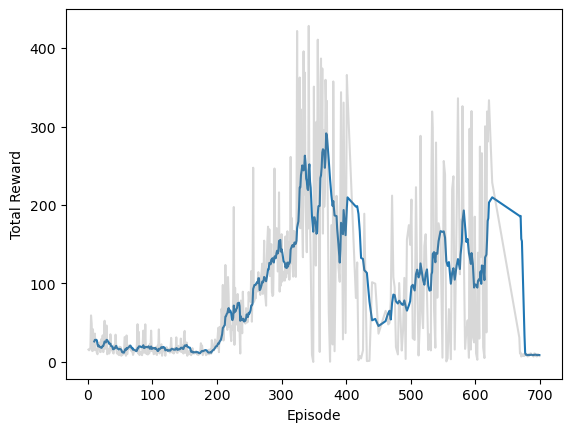

In [125]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Watch a trained agent
Note that the episode ends after 500 steps.

In [126]:
def watch_agent(n_episodes):
    with tf.compat.v1.Session() as sess:
        saver.restore(sess, "C:/Users/Shubham/Downloads/.ipynb_checkpoints/CartPole.ckpt")
        for episode in range(n_episodes):
            state_tuple = env.reset()
            r = 0
            while True:
                r += 1
                state = state_tuple[0]
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
                result = env.step(action)
                state, reward, done, _ = result[0], result[1], result[2], result[3]
                env.render()
                sleep(0.05)
                if done:
                    env.close()
                    print(f"reward: {r}")
                    break


In [127]:
watch_agent(3)

INFO:tensorflow:Restoring parameters from C:/Users/Shubham/Downloads/.ipynb_checkpoints/CartPole.ckpt


C:\Users\Shubham\AppData\Roaming\Python\Python39\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


reward: 9
reward: 10
reward: 9
